# Optimization Project Implementation
## Group 7: Weile Chen, Shaoyu Feng, Chelsea Wang, Yunjia Zeng, Mengtong Zhang

In [6]:
# import packages
import time
import numpy as np
import tensorflow as tf
import random
from collections import Counter

In [9]:
# load data
with open('./data/text8') as f:
    text = f.read()
   
### Preprocessing ###
# define the preprocessing function
def preprocess(text, freq=5):
    """
    text: text data
    freq: frequency threshold
    """
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # for better preformance, delete the low frequency words, reduce noise
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > freq]

    return trimmed_words

# text cleaning and splitting
words = preprocess(text)
print(words[:20])

# construct corpus and vocabulary embedding lookup table
vocab = set(words)
vocab_to_int = {w: c for c, w in enumerate(vocab)}
int_to_vocab = {c: w for c, w in enumerate(vocab)}

# print to see total words
print("\n===== Total Words =====")
print("total words: {}".format(len(words)))
print("\n===== Total Unique Words =====")
print("unique words: {}".format(len(set(words))), "\n")

int_words = [vocab_to_int[w] for w in words]

### Construct Training Set ###

# t value
t = 1e-5 
# threshold of elimination probability
threshold = 0.8 
# word counts
int_word_counts = Counter(int_words)
total_count = len(int_words)
# calculate vocabulary frequency
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}
# calculate elimination probability
prob_drop = {w: 1 - np.sqrt(t / word_freqs[w]) for w in int_word_counts}
# sampling training words
train_words = [w for w in int_words if prob_drop[w] < threshold]

# length of training words
print("\n===== Length of Training Words =====")
print(len(train_words), "\n")

## construct word batch
def get_targets(words, idx, window_size=5):
    """
    words: vocabulary lists
    idx: input word index
    window_size: predefined window size
    """
    target_window = np.random.randint(1, window_size+1)
    # define starting point
    start_point = idx - target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    # output words
    targets = set(words[start_point: idx] + words[idx+1: end_point+1])
    return list(targets)


def get_batches(words, batch_size, window_size=5):
    """
    word batch builder
    """
    n_batches = len(words) // batch_size
    
    # get full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            # make the length of input consistent
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y
        
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')
    
### Model Construction ###
# embedding
vocab_size = len(int_to_vocab)
embedding_size = 200

with train_graph.as_default():
    # embedding layer wight matrix
    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1, 1))
    # construct look up
    embed = tf.nn.embedding_lookup(embedding, inputs)
    
# negative sampling

n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    # calculate negative sampling loss
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
### Model Validation ###
# testing
with train_graph.as_default():
    # random select words
    valid_size = 16 
    valid_window = 100
    # select 8 words
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    
    valid_size = len(valid_examples)
    # set up validating set
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    # normalize embedding
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    # find vector for validating vocabularies
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    # calculate cosine similarity
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))
    
# set parameters
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

train_test_start = time.time()
with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        # 
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            # calculate similar words
            if iteration % 1000 == 0:
                # calculate similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # top 8 similar words
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    save_path = saver.save(sess, "./checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

train_test_end = time.time()
print("\n======Total Train Test Time=======")
print(train_test_end - train_test_start)

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']

===== Total Words =====
total words: 16680599

===== Total Unique Words =====
unique words: 63641 


===== Length of Training Words =====
6925252 

Epoch 1/10 Iteration: 100 Avg. Training loss: 3.6653 0.1880 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 3.5941 0.1920 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 3.6015 0.1949 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 3.5682 0.1927 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 3.5298 0.1800 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 3.4776 0.1846 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 3.4631 0.1965 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 3.4144 0.1902 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 3.3401 0.1854 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Tra

Nearest to [disparities]: imparting, maitre, pawl, swordsman, deshima, pallas, citations, lind,
Nearest to [festival]: tribulation, gab, undocumented, trainers, binds, borrow, turbofan, noguchi,
Nearest to [mispronounced]: streamlining, directed, ucd, overtaken, travelled, fiorello, malory, simonds,
Nearest to [caatinga]: gladly, teleological, sassanids, mildred, sentence, conservatory, cardigan, zollverein,
Nearest to [lav]: mstislav, segregationist, worsening, bluebird, kilometre, want, button, lycaeus,
Nearest to [juliana]: bukovina, ustinov, isa, nin, higson, separately, undying, vermeer,
Nearest to [student]: walking, lagrange, molto, freighters, classless, kristina, unresolved, quantum,
Nearest to [venereal]: fernandez, algiris, martian, pelvic, periodic, uematsu, marathas, solidify,
Nearest to [daerah]: legato, paleontology, expectations, rucker, liga, rampling, illuminatus, vacuum,
Nearest to [domingo]: improvisations, networking, honneur, midwest, urination, emmitt, edgy, affi

Epoch 2/10 Iteration: 7100 Avg. Training loss: 2.3132 0.1917 sec/batch
Epoch 2/10 Iteration: 7200 Avg. Training loss: 2.3311 0.1912 sec/batch
Epoch 2/10 Iteration: 7300 Avg. Training loss: 2.3791 0.1920 sec/batch
Epoch 2/10 Iteration: 7400 Avg. Training loss: 2.3738 0.1920 sec/batch
Epoch 2/10 Iteration: 7500 Avg. Training loss: 2.2262 0.1892 sec/batch
Epoch 2/10 Iteration: 7600 Avg. Training loss: 2.2903 0.1919 sec/batch
Epoch 2/10 Iteration: 7700 Avg. Training loss: 2.3768 0.1899 sec/batch
Epoch 2/10 Iteration: 7800 Avg. Training loss: 2.2686 0.1910 sec/batch
Epoch 2/10 Iteration: 7900 Avg. Training loss: 2.3416 0.1904 sec/batch
Epoch 2/10 Iteration: 8000 Avg. Training loss: 2.2130 0.1900 sec/batch
Nearest to [swimmers]: hajj, polymyositis, edwina, belfry, trainspotting, shots, sandy, atherton,
Nearest to [clemente]: mitsuda, pared, radiating, endosymbiotic, ncbi, kaj, yeshiva, ojibwe,
Nearest to [coordinates]: equivalence, steroids, familes, thicker, hemphill, converge, eavesdropper

Epoch 2/10 Iteration: 11100 Avg. Training loss: 2.1584 0.1961 sec/batch
Epoch 2/10 Iteration: 11200 Avg. Training loss: 2.4038 0.1887 sec/batch
Epoch 2/10 Iteration: 11300 Avg. Training loss: 2.1560 0.1910 sec/batch
Epoch 2/10 Iteration: 11400 Avg. Training loss: 2.2546 0.1919 sec/batch
Epoch 2/10 Iteration: 11500 Avg. Training loss: 2.2374 0.1879 sec/batch
Epoch 2/10 Iteration: 11600 Avg. Training loss: 2.2514 0.1915 sec/batch
Epoch 2/10 Iteration: 11700 Avg. Training loss: 2.2374 0.1916 sec/batch
Epoch 2/10 Iteration: 11800 Avg. Training loss: 2.0772 0.1874 sec/batch
Epoch 2/10 Iteration: 11900 Avg. Training loss: 2.1486 0.1884 sec/batch
Epoch 2/10 Iteration: 12000 Avg. Training loss: 2.2226 0.1879 sec/batch
Nearest to [swimmers]: trainspotting, edwina, polymyositis, atherton, hajj, shots, belfry, sandy,
Nearest to [clemente]: mitsuda, pared, radiating, kaj, ncbi, endosymbiotic, yeshiva, amid,
Nearest to [coordinates]: equivalence, steroids, thicker, hemphill, germanisation, familes,

Epoch 3/10 Iteration: 15100 Avg. Training loss: 2.0472 0.1939 sec/batch
Epoch 3/10 Iteration: 15200 Avg. Training loss: 2.1978 0.1898 sec/batch
Epoch 3/10 Iteration: 15300 Avg. Training loss: 2.1274 0.1931 sec/batch
Epoch 3/10 Iteration: 15400 Avg. Training loss: 2.1475 0.1916 sec/batch
Epoch 3/10 Iteration: 15500 Avg. Training loss: 2.1174 0.1903 sec/batch
Epoch 3/10 Iteration: 15600 Avg. Training loss: 2.0612 0.1902 sec/batch
Epoch 3/10 Iteration: 15700 Avg. Training loss: 2.0074 0.1908 sec/batch
Epoch 3/10 Iteration: 15800 Avg. Training loss: 1.9969 0.1914 sec/batch
Epoch 3/10 Iteration: 15900 Avg. Training loss: 2.1127 0.1899 sec/batch
Epoch 3/10 Iteration: 16000 Avg. Training loss: 2.2109 0.1898 sec/batch
Nearest to [swimmers]: trainspotting, atherton, psp, edwina, hajj, regiments, belfry, active,
Nearest to [clemente]: mitsuda, pared, kaj, radiating, endosymbiotic, ncbi, ojibwe, prefectural,
Nearest to [coordinates]: equivalence, converge, steroids, hemphill, familes, thicker, ge

Epoch 3/10 Iteration: 19100 Avg. Training loss: 2.1142 0.1777 sec/batch
Epoch 3/10 Iteration: 19200 Avg. Training loss: 2.1334 0.1649 sec/batch
Epoch 3/10 Iteration: 19300 Avg. Training loss: 2.0817 0.1651 sec/batch
Epoch 3/10 Iteration: 19400 Avg. Training loss: 2.0694 0.1630 sec/batch
Epoch 3/10 Iteration: 19500 Avg. Training loss: 2.0964 0.1761 sec/batch
Epoch 3/10 Iteration: 19600 Avg. Training loss: 2.2084 0.1910 sec/batch
Epoch 3/10 Iteration: 19700 Avg. Training loss: 1.9764 0.1909 sec/batch
Epoch 3/10 Iteration: 19800 Avg. Training loss: 2.1153 0.1907 sec/batch
Epoch 3/10 Iteration: 19900 Avg. Training loss: 2.1504 0.1885 sec/batch
Epoch 3/10 Iteration: 20000 Avg. Training loss: 2.1888 0.1892 sec/batch
Nearest to [swimmers]: atherton, trainspotting, active, edwina, regiments, hajj, jtf, psp,
Nearest to [clemente]: mitsuda, kaj, pared, radiating, ojibwe, endosymbiotic, ncbi, lasi,
Nearest to [coordinates]: equivalence, converge, hemphill, germanisation, familes, thicker, deputy,

Epoch 4/10 Iteration: 23100 Avg. Training loss: 2.1151 0.1952 sec/batch
Epoch 4/10 Iteration: 23200 Avg. Training loss: 1.9732 0.1922 sec/batch
Epoch 4/10 Iteration: 23300 Avg. Training loss: 2.0329 0.1898 sec/batch
Epoch 4/10 Iteration: 23400 Avg. Training loss: 2.0399 0.1911 sec/batch
Epoch 4/10 Iteration: 23500 Avg. Training loss: 2.1218 0.1904 sec/batch
Epoch 4/10 Iteration: 23600 Avg. Training loss: 2.0882 0.1801 sec/batch
Epoch 4/10 Iteration: 23700 Avg. Training loss: 2.1488 0.1840 sec/batch
Epoch 4/10 Iteration: 23800 Avg. Training loss: 1.9963 0.1897 sec/batch
Epoch 4/10 Iteration: 23900 Avg. Training loss: 1.9243 0.1902 sec/batch
Epoch 4/10 Iteration: 24000 Avg. Training loss: 2.1810 0.1906 sec/batch
Nearest to [swimmers]: atherton, trainspotting, hajj, active, et, regiments, jtf, edwina,
Nearest to [clemente]: mitsuda, kaj, radiating, pared, ojibwe, endosymbiotic, leiserson, ascalon,
Nearest to [coordinates]: equivalence, converge, hemphill, germanisation, familes, unciviliz

Epoch 4/10 Iteration: 27100 Avg. Training loss: 1.8466 0.1942 sec/batch
Epoch 4/10 Iteration: 27200 Avg. Training loss: 2.0453 0.1921 sec/batch
Epoch 4/10 Iteration: 27300 Avg. Training loss: 2.0342 0.1900 sec/batch
Epoch 4/10 Iteration: 27400 Avg. Training loss: 2.0556 0.1693 sec/batch
Epoch 4/10 Iteration: 27500 Avg. Training loss: 2.0569 0.1910 sec/batch
Epoch 4/10 Iteration: 27600 Avg. Training loss: 2.0424 0.1907 sec/batch
Epoch 4/10 Iteration: 27700 Avg. Training loss: 2.2143 0.1911 sec/batch
Epoch 5/10 Iteration: 27800 Avg. Training loss: 2.0216 0.1920 sec/batch
Epoch 5/10 Iteration: 27900 Avg. Training loss: 2.0908 0.1924 sec/batch
Epoch 5/10 Iteration: 28000 Avg. Training loss: 1.9557 0.1754 sec/batch
Nearest to [swimmers]: atherton, trainspotting, hajj, jtf, edwina, active, regiments, psp,
Nearest to [clemente]: mitsuda, kaj, radiating, pared, ojibwe, ascalon, leiserson, dustin,
Nearest to [coordinates]: converge, equivalence, germanisation, uncivilized, deputy, hemphill, fam

Epoch 5/10 Iteration: 31100 Avg. Training loss: 1.9749 0.1937 sec/batch
Epoch 5/10 Iteration: 31200 Avg. Training loss: 1.8950 0.1897 sec/batch
Epoch 5/10 Iteration: 31300 Avg. Training loss: 2.0721 0.1914 sec/batch
Epoch 5/10 Iteration: 31400 Avg. Training loss: 2.0357 0.1895 sec/batch
Epoch 5/10 Iteration: 31500 Avg. Training loss: 2.0069 0.1928 sec/batch
Epoch 5/10 Iteration: 31600 Avg. Training loss: 1.9897 0.1911 sec/batch
Epoch 5/10 Iteration: 31700 Avg. Training loss: 1.9297 0.1908 sec/batch
Epoch 5/10 Iteration: 31800 Avg. Training loss: 2.0865 0.1916 sec/batch
Epoch 5/10 Iteration: 31900 Avg. Training loss: 2.1183 0.1926 sec/batch
Epoch 5/10 Iteration: 32000 Avg. Training loss: 2.1035 0.1936 sec/batch
Nearest to [swimmers]: atherton, trainspotting, hajj, jtf, active, leaded, edwina, regiments,
Nearest to [clemente]: mitsuda, kaj, ojibwe, radiating, pared, leiserson, lasi, ascalon,
Nearest to [coordinates]: converge, equivalence, thicker, uncivilized, germanisation, hemphill, d

Epoch 6/10 Iteration: 35100 Avg. Training loss: 2.0621 0.1983 sec/batch
Epoch 6/10 Iteration: 35200 Avg. Training loss: 2.0422 0.1906 sec/batch
Epoch 6/10 Iteration: 35300 Avg. Training loss: 2.0298 0.1930 sec/batch
Epoch 6/10 Iteration: 35400 Avg. Training loss: 2.1243 0.1942 sec/batch
Epoch 6/10 Iteration: 35500 Avg. Training loss: 1.9985 0.1703 sec/batch
Epoch 6/10 Iteration: 35600 Avg. Training loss: 1.9744 0.1661 sec/batch
Epoch 6/10 Iteration: 35700 Avg. Training loss: 1.9864 0.1638 sec/batch
Epoch 6/10 Iteration: 35800 Avg. Training loss: 2.0154 0.1637 sec/batch
Epoch 6/10 Iteration: 35900 Avg. Training loss: 2.0301 0.1638 sec/batch
Epoch 6/10 Iteration: 36000 Avg. Training loss: 1.9885 0.1634 sec/batch
Nearest to [swimmers]: atherton, trainspotting, active, hajj, jtf, leaded, edwina, tragedians,
Nearest to [clemente]: kaj, mitsuda, leiserson, ojibwe, pared, radiating, lasi, mismeasure,
Nearest to [coordinates]: converge, uncivilized, thicker, equivalence, germanisation, familes

Epoch 6/10 Iteration: 39100 Avg. Training loss: 1.9710 0.1958 sec/batch
Epoch 6/10 Iteration: 39200 Avg. Training loss: 1.9279 0.1927 sec/batch
Epoch 6/10 Iteration: 39300 Avg. Training loss: 1.9689 0.1917 sec/batch
Epoch 6/10 Iteration: 39400 Avg. Training loss: 2.0942 0.1933 sec/batch
Epoch 6/10 Iteration: 39500 Avg. Training loss: 1.9521 0.1923 sec/batch
Epoch 6/10 Iteration: 39600 Avg. Training loss: 1.8607 0.1906 sec/batch
Epoch 6/10 Iteration: 39700 Avg. Training loss: 1.9635 0.1919 sec/batch
Epoch 6/10 Iteration: 39800 Avg. Training loss: 2.0313 0.1904 sec/batch
Epoch 6/10 Iteration: 39900 Avg. Training loss: 2.0868 0.1951 sec/batch
Epoch 6/10 Iteration: 40000 Avg. Training loss: 2.0176 0.1939 sec/batch
Nearest to [swimmers]: atherton, jtf, leaded, hajj, trainspotting, dodo, flag, royal,
Nearest to [clemente]: mitsuda, kaj, leiserson, ojibwe, radiating, lasi, pared, mismeasure,
Nearest to [coordinates]: converge, equivalence, uncivilized, thicker, germanisation, familes, deputy,

Nearest to [venereal]: fernandez, pelvic, solidify, bradycardia, algiris, landlords, lex, platt,
Nearest to [daerah]: bottomed, dictate, mixtec, legato, prisoners, liga, bmi, paleontology,
Nearest to [domingo]: networking, emmitt, honneur, kommune, vocation, aegean, midwest, pld,
Nearest to [gratification]: dependency, handover, pills, tefan, dostoevsky, complication, throne, lak,
Nearest to [byzantines]: isolated, sixths, nassau, ambrosian, pge, nahua, macduff, hospitable,
Nearest to [nucleophilic]: pyridine, suv, starbucks, royalist, oxidized, cnbc, kievan, ordering,
Epoch 7/10 Iteration: 43100 Avg. Training loss: 2.0755 0.1821 sec/batch
Epoch 7/10 Iteration: 43200 Avg. Training loss: 1.9070 0.1984 sec/batch
Epoch 7/10 Iteration: 43300 Avg. Training loss: 1.7598 0.1945 sec/batch
Epoch 7/10 Iteration: 43400 Avg. Training loss: 2.0753 0.1956 sec/batch
Epoch 7/10 Iteration: 43500 Avg. Training loss: 1.9165 0.1922 sec/batch
Epoch 7/10 Iteration: 43600 Avg. Training loss: 1.9964 0.1946 se

Nearest to [coordinates]: converge, thicker, uncivilized, familes, equivalence, germanisation, deputy, mythbusters,
Nearest to [disparities]: deshima, imparting, pawl, pallas, maitre, fastest, aerosols, voluminous,
Nearest to [festival]: entering, tribulation, hemisphere, vishnu, noguchi, caldera, annual, islamiyah,
Nearest to [mispronounced]: streamlining, fiorello, cajun, rasa, odilo, lemnos, parodied, directed,
Nearest to [caatinga]: halpin, downwind, plumes, teleological, exclave, sentence, zollverein, spines,
Nearest to [lav]: mstislav, segregationist, aegisthus, worsening, rosy, button, winding, verdean,
Nearest to [juliana]: bukovina, ustinov, novello, nin, separately, dinah, grohl, isa,
Nearest to [student]: eritreans, attended, crazy, students, pilar, assisi, endowment, kindergarten,
Nearest to [venereal]: fernandez, pelvic, inject, solidify, landlords, dhcp, algiris, platt,
Nearest to [daerah]: mixtec, bottomed, dictate, legato, prisoners, concluding, bmi, liga,
Nearest to [d

Epoch 8/10 Iteration: 50100 Avg. Training loss: 1.8623 0.1969 sec/batch
Epoch 8/10 Iteration: 50200 Avg. Training loss: 1.7510 0.1943 sec/batch
Epoch 8/10 Iteration: 50300 Avg. Training loss: 1.9541 0.1969 sec/batch
Epoch 8/10 Iteration: 50400 Avg. Training loss: 1.8874 0.1937 sec/batch
Epoch 8/10 Iteration: 50500 Avg. Training loss: 2.0612 0.1956 sec/batch
Epoch 8/10 Iteration: 50600 Avg. Training loss: 1.9850 0.1938 sec/batch
Epoch 8/10 Iteration: 50700 Avg. Training loss: 2.0525 0.1950 sec/batch
Epoch 8/10 Iteration: 50800 Avg. Training loss: 1.9164 0.1934 sec/batch
Epoch 8/10 Iteration: 50900 Avg. Training loss: 1.9446 0.1936 sec/batch
Epoch 8/10 Iteration: 51000 Avg. Training loss: 1.9201 0.1747 sec/batch
Nearest to [swimmers]: atherton, jtf, leaded, royal, sailboat, tempus, dodo, flag,
Nearest to [clemente]: kaj, mitsuda, leiserson, ojibwe, mismeasure, sixes, radiating, dustin,
Nearest to [coordinates]: uncivilized, thicker, converge, familes, germanisation, egyptologists, equiva

Epoch 8/10 Iteration: 54100 Avg. Training loss: 1.9401 0.1968 sec/batch
Epoch 8/10 Iteration: 54200 Avg. Training loss: 2.0564 0.1963 sec/batch
Epoch 8/10 Iteration: 54300 Avg. Training loss: 2.1256 0.1811 sec/batch
Epoch 8/10 Iteration: 54400 Avg. Training loss: 1.9590 0.1648 sec/batch
Epoch 8/10 Iteration: 54500 Avg. Training loss: 2.0977 0.1628 sec/batch
Epoch 8/10 Iteration: 54600 Avg. Training loss: 1.9780 0.1699 sec/batch
Epoch 8/10 Iteration: 54700 Avg. Training loss: 2.1167 0.1951 sec/batch
Epoch 8/10 Iteration: 54800 Avg. Training loss: 1.8145 0.1929 sec/batch
Epoch 8/10 Iteration: 54900 Avg. Training loss: 1.9790 0.1974 sec/batch
Epoch 8/10 Iteration: 55000 Avg. Training loss: 1.9355 0.1932 sec/batch
Nearest to [swimmers]: atherton, jtf, royal, edwina, leaded, dodo, flag, tempus,
Nearest to [clemente]: kaj, mitsuda, leiserson, ojibwe, mismeasure, sixes, dustin, lasi,
Nearest to [coordinates]: uncivilized, thicker, converge, familes, germanisation, egyptologists, equivalence, 

Epoch 9/10 Iteration: 58100 Avg. Training loss: 2.0923 0.1966 sec/batch
Epoch 9/10 Iteration: 58200 Avg. Training loss: 2.0289 0.1974 sec/batch
Epoch 9/10 Iteration: 58300 Avg. Training loss: 1.8645 0.1957 sec/batch
Epoch 9/10 Iteration: 58400 Avg. Training loss: 1.9100 0.1929 sec/batch
Epoch 9/10 Iteration: 58500 Avg. Training loss: 1.9273 0.1926 sec/batch
Epoch 9/10 Iteration: 58600 Avg. Training loss: 2.0734 0.1810 sec/batch
Epoch 9/10 Iteration: 58700 Avg. Training loss: 2.0010 0.1944 sec/batch
Epoch 9/10 Iteration: 58800 Avg. Training loss: 2.0200 0.1958 sec/batch
Epoch 9/10 Iteration: 58900 Avg. Training loss: 2.0135 0.1940 sec/batch
Epoch 9/10 Iteration: 59000 Avg. Training loss: 1.9834 0.1712 sec/batch
Nearest to [swimmers]: flag, jtf, atherton, royal, edwina, aldershot, tempus, dodo,
Nearest to [clemente]: mitsuda, kaj, leiserson, ojibwe, sixes, radiating, mismeasure, dustin,
Nearest to [coordinates]: uncivilized, familes, converge, thicker, germanisation, egyptologists, equiv

Epoch 9/10 Iteration: 62100 Avg. Training loss: 2.1038 0.1806 sec/batch
Epoch 9/10 Iteration: 62200 Avg. Training loss: 2.0205 0.1732 sec/batch
Epoch 9/10 Iteration: 62300 Avg. Training loss: 2.1704 0.1956 sec/batch
Epoch 10/10 Iteration: 62400 Avg. Training loss: 2.0320 0.1464 sec/batch
Epoch 10/10 Iteration: 62500 Avg. Training loss: 1.9372 0.1984 sec/batch
Epoch 10/10 Iteration: 62600 Avg. Training loss: 2.0589 0.1973 sec/batch
Epoch 10/10 Iteration: 62700 Avg. Training loss: 2.1013 0.1968 sec/batch
Epoch 10/10 Iteration: 62800 Avg. Training loss: 2.0213 0.1970 sec/batch
Epoch 10/10 Iteration: 62900 Avg. Training loss: 1.9936 0.1945 sec/batch
Epoch 10/10 Iteration: 63000 Avg. Training loss: 2.0904 0.1949 sec/batch
Nearest to [swimmers]: jtf, flag, atherton, edwina, aldershot, royal, tempus, dodo,
Nearest to [clemente]: mitsuda, kaj, ojibwe, leiserson, sixes, mismeasure, radiating, dustin,
Nearest to [coordinates]: thicker, uncivilized, familes, converge, germanisation, disbandment, 

Epoch 10/10 Iteration: 66100 Avg. Training loss: 2.0619 0.1949 sec/batch
Epoch 10/10 Iteration: 66200 Avg. Training loss: 2.0696 0.1948 sec/batch
Epoch 10/10 Iteration: 66300 Avg. Training loss: 1.8281 0.1934 sec/batch
Epoch 10/10 Iteration: 66400 Avg. Training loss: 2.0237 0.1820 sec/batch
Epoch 10/10 Iteration: 66500 Avg. Training loss: 2.0790 0.1677 sec/batch
Epoch 10/10 Iteration: 66600 Avg. Training loss: 2.1055 0.1726 sec/batch
Epoch 10/10 Iteration: 66700 Avg. Training loss: 1.9258 0.1843 sec/batch
Epoch 10/10 Iteration: 66800 Avg. Training loss: 1.8861 0.1826 sec/batch
Epoch 10/10 Iteration: 66900 Avg. Training loss: 1.9498 0.1934 sec/batch
Epoch 10/10 Iteration: 67000 Avg. Training loss: 2.0298 0.1937 sec/batch
Nearest to [swimmers]: flag, jtf, edwina, dodo, tempus, sugary, atherton, leaded,
Nearest to [clemente]: mitsuda, kaj, leiserson, ojibwe, sixes, mismeasure, mayol, dustin,
Nearest to [coordinates]: thicker, familes, uncivilized, egyptologists, converge, andromeda, stero

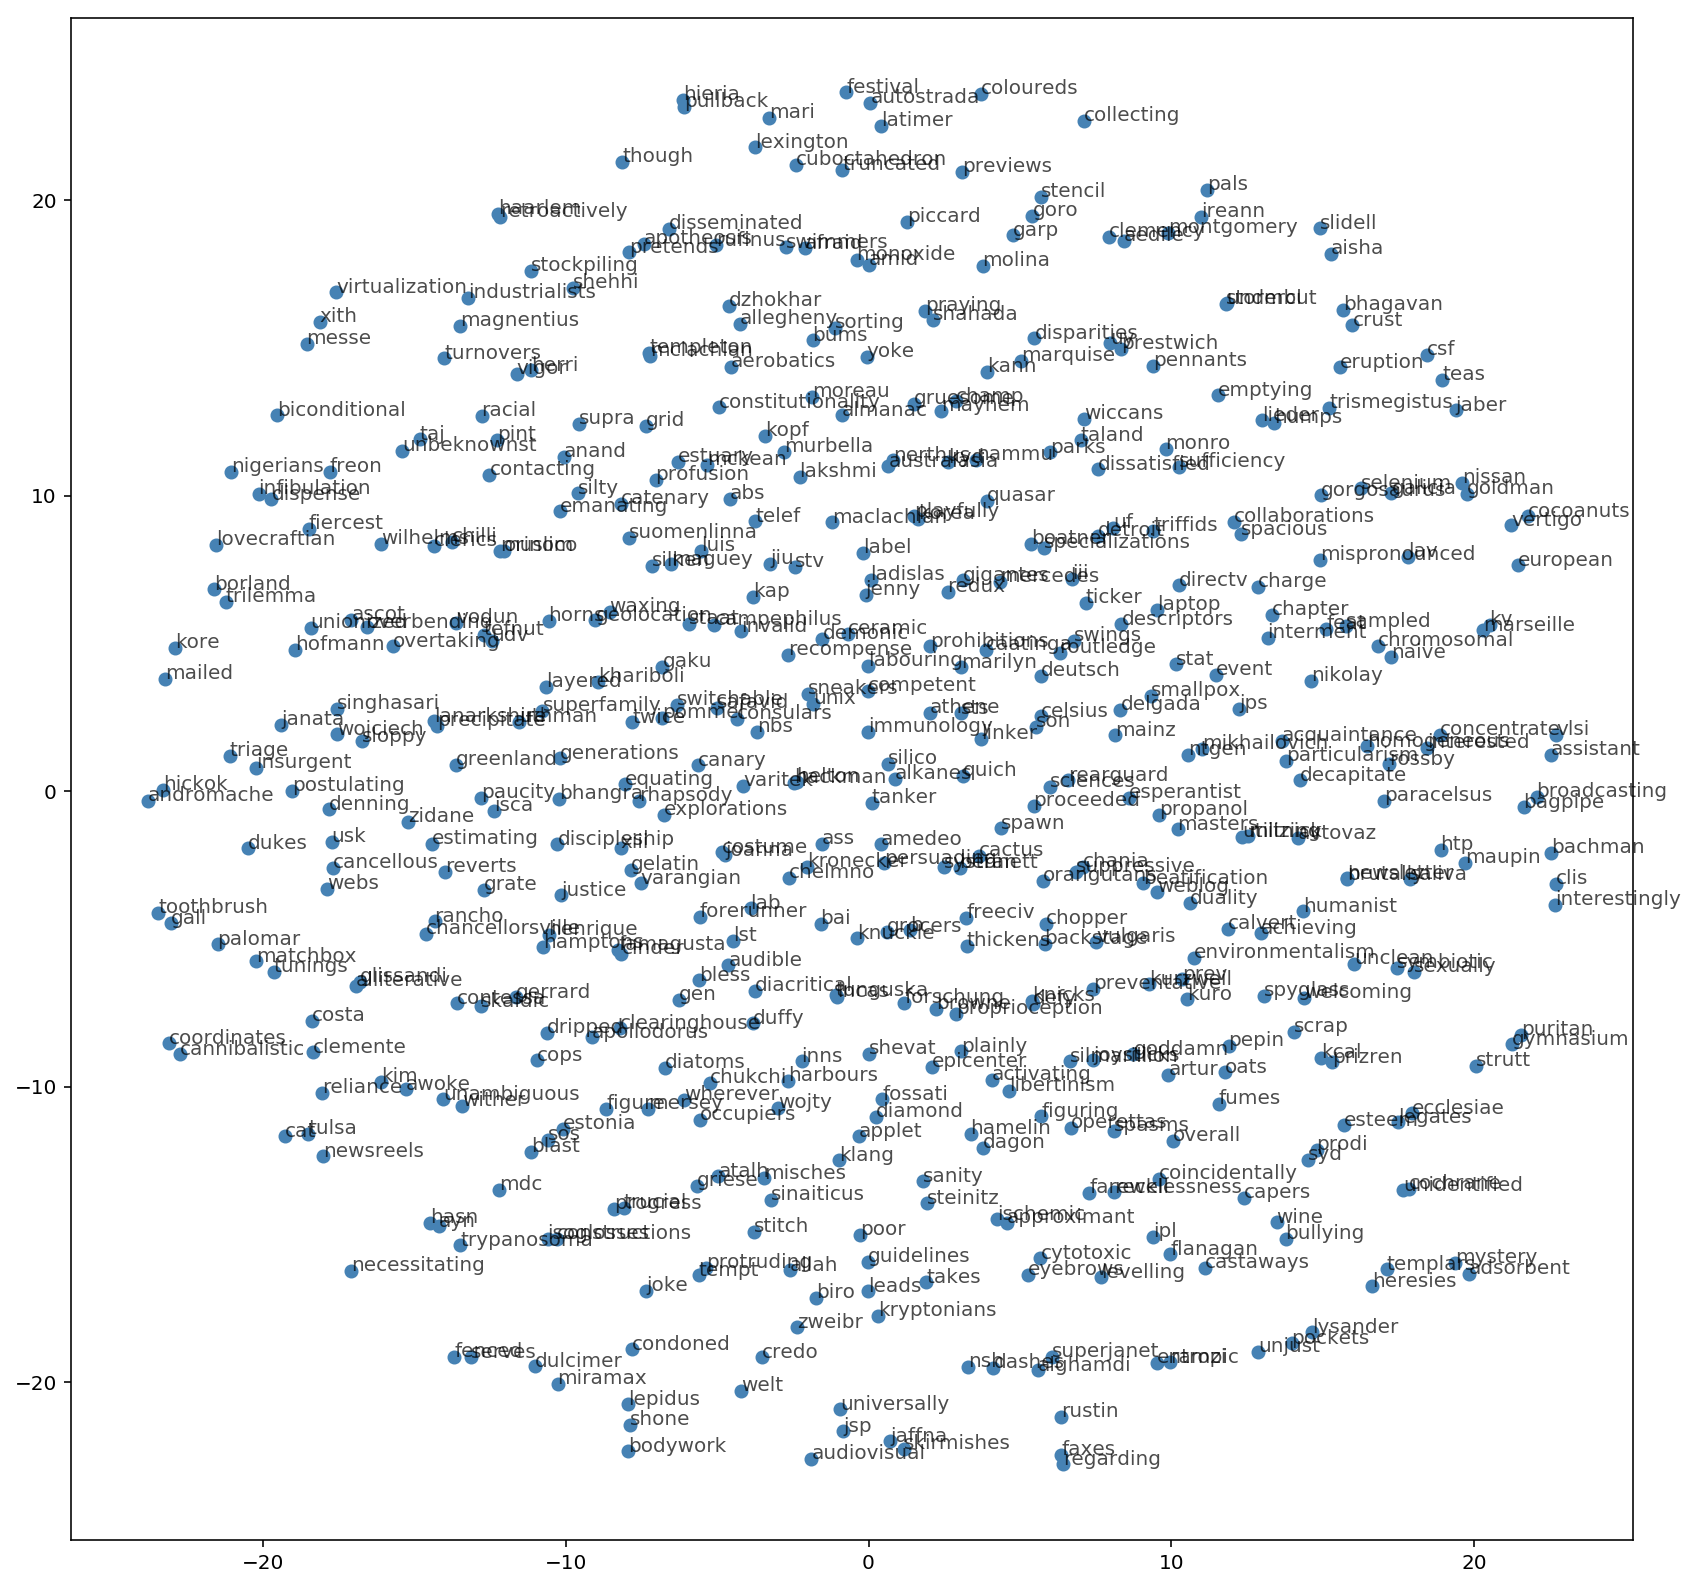

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    
plt.savefig("result_adam.jpg")

In [7]:
## with SGD
# load data
with open('./data/text8') as f:
    text = f.read()
    
def preprocess(text, freq=5):
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > freq]

    return trimmed_words

words = preprocess(text)
print(words[:20])

vocab = set(words)
vocab_to_int = {w: c for c, w in enumerate(vocab)}
int_to_vocab = {c: w for c, w in enumerate(vocab)}

# print to see total words
print("\n===== Total Words =====")
print("total words: {}".format(len(words)))
print("\n===== Total Unique Words =====")
print("unique words: {}".format(len(set(words))), "\n")

int_words = [vocab_to_int[w] for w in words]

t = 1e-5 
threshold = 0.8 

int_word_counts = Counter(int_words)
total_count = len(int_words)

word_freqs = {w: c/total_count for w, c in int_word_counts.items()}

prob_drop = {w: 1 - np.sqrt(t / word_freqs[w]) for w in int_word_counts}

train_words = [w for w in int_words if prob_drop[w] < threshold]

# length of training words
print("\n===== Length of Training Words =====")
print(len(train_words), "\n")

def get_targets(words, idx, window_size=5):
    target_window = np.random.randint(1, window_size+1)
    start_point = idx - target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    targets = set(words[start_point: idx] + words[idx+1: end_point+1])
    return list(targets)


def get_batches(words, batch_size, window_size=5):
    n_batches = len(words) // batch_size
    
    # get full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y
        
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')
    

# embedding
vocab_size = len(int_to_vocab)
embedding_size = 200

with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)
    
# negative sampling

n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    # calculate negative sampling loss
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(cost)
    
# testing
with train_graph.as_default():
    valid_size = 16 
    valid_window = 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    
    valid_size = len(valid_examples)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))
    
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

train_test_start = time.time()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        # 
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            # calculate similar words
            if iteration % 1000 == 0:
                # calculate similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # top 8 similar words
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    save_path = saver.save(sess, "./checkpoints/text8_SGD.ckpt")
    embed_mat = sess.run(normalized_embedding)
    
train_test_end = time.time()
print("======Total Train Test Time=======")
print(train_test_end - train_test_start)

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']

===== Total Words =====
total words: 16680599

===== Total Unique Words =====
unique words: 63641 


===== Length of Training Words =====
6925252 

Epoch 1/10 Iteration: 100 Avg. Training loss: 3.6585 0.0473 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 3.6207 0.0440 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 3.6399 0.0472 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 3.6822 0.0450 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 3.6878 0.0448 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 3.6883 0.0432 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 3.6371 0.0433 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 3.6475 0.0434 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 3.6187 0.0441 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Tra

Epoch 1/10 Iteration: 4100 Avg. Training loss: 3.6445 0.0468 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 3.6295 0.0431 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 3.6334 0.0445 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 3.6528 0.0440 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 3.6494 0.0448 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 3.6388 0.0438 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 3.6875 0.0433 sec/batch
Epoch 1/10 Iteration: 4800 Avg. Training loss: 3.6518 0.0431 sec/batch
Epoch 1/10 Iteration: 4900 Avg. Training loss: 3.6238 0.0431 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 3.6375 0.0424 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle, otherness

Epoch 2/10 Iteration: 8100 Avg. Training loss: 3.6374 0.0473 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 3.6418 0.0450 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 3.6109 0.0434 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 3.6028 0.0443 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 3.6446 0.0443 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 3.6147 0.0433 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 3.6386 0.0439 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 3.6376 0.0442 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 3.6088 0.0456 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 3.6491 0.0451 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle, otherness

Epoch 2/10 Iteration: 12100 Avg. Training loss: 3.6468 0.0484 sec/batch
Epoch 2/10 Iteration: 12200 Avg. Training loss: 3.6483 0.0460 sec/batch
Epoch 2/10 Iteration: 12300 Avg. Training loss: 3.6624 0.0469 sec/batch
Epoch 2/10 Iteration: 12400 Avg. Training loss: 3.6151 0.0458 sec/batch
Epoch 2/10 Iteration: 12500 Avg. Training loss: 3.6145 0.0458 sec/batch
Epoch 2/10 Iteration: 12600 Avg. Training loss: 3.6513 0.0448 sec/batch
Epoch 2/10 Iteration: 12700 Avg. Training loss: 3.5860 0.0440 sec/batch
Epoch 2/10 Iteration: 12800 Avg. Training loss: 3.6314 0.0445 sec/batch
Epoch 2/10 Iteration: 12900 Avg. Training loss: 3.6514 0.0466 sec/batch
Epoch 2/10 Iteration: 13000 Avg. Training loss: 3.6188 0.0465 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 3/10 Iteration: 16100 Avg. Training loss: 3.6224 0.0489 sec/batch
Epoch 3/10 Iteration: 16200 Avg. Training loss: 3.6496 0.0447 sec/batch
Epoch 3/10 Iteration: 16300 Avg. Training loss: 3.6375 0.0454 sec/batch
Epoch 3/10 Iteration: 16400 Avg. Training loss: 3.6501 0.0443 sec/batch
Epoch 3/10 Iteration: 16500 Avg. Training loss: 3.6013 0.0447 sec/batch
Epoch 3/10 Iteration: 16600 Avg. Training loss: 3.6321 0.0445 sec/batch
Epoch 3/10 Iteration: 16700 Avg. Training loss: 3.6418 0.0459 sec/batch
Epoch 3/10 Iteration: 16800 Avg. Training loss: 3.6281 0.0445 sec/batch
Epoch 3/10 Iteration: 16900 Avg. Training loss: 3.6411 0.0445 sec/batch
Epoch 3/10 Iteration: 17000 Avg. Training loss: 3.6126 0.0440 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 3/10 Iteration: 20100 Avg. Training loss: 3.5966 0.0461 sec/batch
Epoch 3/10 Iteration: 20200 Avg. Training loss: 3.6475 0.0403 sec/batch
Epoch 3/10 Iteration: 20300 Avg. Training loss: 3.6005 0.0410 sec/batch
Epoch 3/10 Iteration: 20400 Avg. Training loss: 3.6064 0.0423 sec/batch
Epoch 3/10 Iteration: 20500 Avg. Training loss: 3.6220 0.0420 sec/batch
Epoch 3/10 Iteration: 20600 Avg. Training loss: 3.6091 0.0413 sec/batch
Epoch 3/10 Iteration: 20700 Avg. Training loss: 3.6216 0.0415 sec/batch
Epoch 4/10 Iteration: 20800 Avg. Training loss: 3.6537 0.0114 sec/batch
Epoch 4/10 Iteration: 20900 Avg. Training loss: 3.6337 0.0455 sec/batch
Epoch 4/10 Iteration: 21000 Avg. Training loss: 3.6136 0.0453 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 4/10 Iteration: 24100 Avg. Training loss: 3.5830 0.0474 sec/batch
Epoch 4/10 Iteration: 24200 Avg. Training loss: 3.6440 0.0441 sec/batch
Epoch 4/10 Iteration: 24300 Avg. Training loss: 3.6021 0.0442 sec/batch
Epoch 4/10 Iteration: 24400 Avg. Training loss: 3.6178 0.0453 sec/batch
Epoch 4/10 Iteration: 24500 Avg. Training loss: 3.6113 0.0430 sec/batch
Epoch 4/10 Iteration: 24600 Avg. Training loss: 3.5950 0.0449 sec/batch
Epoch 4/10 Iteration: 24700 Avg. Training loss: 3.6199 0.0446 sec/batch
Epoch 4/10 Iteration: 24800 Avg. Training loss: 3.6282 0.0441 sec/batch
Epoch 4/10 Iteration: 24900 Avg. Training loss: 3.5984 0.0442 sec/batch
Epoch 4/10 Iteration: 25000 Avg. Training loss: 3.6105 0.0444 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 5/10 Iteration: 28100 Avg. Training loss: 3.6295 0.0499 sec/batch
Epoch 5/10 Iteration: 28200 Avg. Training loss: 3.6183 0.0466 sec/batch
Epoch 5/10 Iteration: 28300 Avg. Training loss: 3.6371 0.0459 sec/batch
Epoch 5/10 Iteration: 28400 Avg. Training loss: 3.6323 0.0471 sec/batch
Epoch 5/10 Iteration: 28500 Avg. Training loss: 3.6149 0.0457 sec/batch
Epoch 5/10 Iteration: 28600 Avg. Training loss: 3.6059 0.0465 sec/batch
Epoch 5/10 Iteration: 28700 Avg. Training loss: 3.5732 0.0446 sec/batch
Epoch 5/10 Iteration: 28800 Avg. Training loss: 3.6033 0.0447 sec/batch
Epoch 5/10 Iteration: 28900 Avg. Training loss: 3.6080 0.0445 sec/batch
Epoch 5/10 Iteration: 29000 Avg. Training loss: 3.6054 0.0447 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 5/10 Iteration: 32100 Avg. Training loss: 3.5578 0.0505 sec/batch
Epoch 5/10 Iteration: 32200 Avg. Training loss: 3.6052 0.0452 sec/batch
Epoch 5/10 Iteration: 32300 Avg. Training loss: 3.6214 0.0453 sec/batch
Epoch 5/10 Iteration: 32400 Avg. Training loss: 3.6415 0.0453 sec/batch
Epoch 5/10 Iteration: 32500 Avg. Training loss: 3.5993 0.0446 sec/batch
Epoch 5/10 Iteration: 32600 Avg. Training loss: 3.6147 0.0445 sec/batch
Epoch 5/10 Iteration: 32700 Avg. Training loss: 3.6016 0.0440 sec/batch
Epoch 5/10 Iteration: 32800 Avg. Training loss: 3.6313 0.0442 sec/batch
Epoch 5/10 Iteration: 32900 Avg. Training loss: 3.5618 0.0449 sec/batch
Epoch 5/10 Iteration: 33000 Avg. Training loss: 3.6465 0.0473 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 6/10 Iteration: 36100 Avg. Training loss: 3.6278 0.0492 sec/batch
Epoch 6/10 Iteration: 36200 Avg. Training loss: 3.6044 0.0449 sec/batch
Epoch 6/10 Iteration: 36300 Avg. Training loss: 3.6112 0.0457 sec/batch
Epoch 6/10 Iteration: 36400 Avg. Training loss: 3.6274 0.0448 sec/batch
Epoch 6/10 Iteration: 36500 Avg. Training loss: 3.6018 0.0459 sec/batch
Epoch 6/10 Iteration: 36600 Avg. Training loss: 3.5948 0.0451 sec/batch
Epoch 6/10 Iteration: 36700 Avg. Training loss: 3.6278 0.0448 sec/batch
Epoch 6/10 Iteration: 36800 Avg. Training loss: 3.6281 0.0441 sec/batch
Epoch 6/10 Iteration: 36900 Avg. Training loss: 3.5856 0.0450 sec/batch
Epoch 6/10 Iteration: 37000 Avg. Training loss: 3.5967 0.0445 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 6/10 Iteration: 40100 Avg. Training loss: 3.6114 0.0505 sec/batch
Epoch 6/10 Iteration: 40200 Avg. Training loss: 3.5779 0.0477 sec/batch
Epoch 6/10 Iteration: 40300 Avg. Training loss: 3.6045 0.0444 sec/batch
Epoch 6/10 Iteration: 40400 Avg. Training loss: 3.6064 0.0453 sec/batch
Epoch 6/10 Iteration: 40500 Avg. Training loss: 3.5792 0.0463 sec/batch
Epoch 6/10 Iteration: 40600 Avg. Training loss: 3.5634 0.0466 sec/batch
Epoch 6/10 Iteration: 40700 Avg. Training loss: 3.6257 0.0446 sec/batch
Epoch 6/10 Iteration: 40800 Avg. Training loss: 3.5668 0.0448 sec/batch
Epoch 6/10 Iteration: 40900 Avg. Training loss: 3.5951 0.0456 sec/batch
Epoch 6/10 Iteration: 41000 Avg. Training loss: 3.6050 0.0449 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 7/10 Iteration: 44100 Avg. Training loss: 3.6275 0.0482 sec/batch
Epoch 7/10 Iteration: 44200 Avg. Training loss: 3.5842 0.0456 sec/batch
Epoch 7/10 Iteration: 44300 Avg. Training loss: 3.6032 0.0461 sec/batch
Epoch 7/10 Iteration: 44400 Avg. Training loss: 3.6076 0.0464 sec/batch
Epoch 7/10 Iteration: 44500 Avg. Training loss: 3.5684 0.0464 sec/batch
Epoch 7/10 Iteration: 44600 Avg. Training loss: 3.5806 0.0456 sec/batch
Epoch 7/10 Iteration: 44700 Avg. Training loss: 3.5658 0.0448 sec/batch
Epoch 7/10 Iteration: 44800 Avg. Training loss: 3.6013 0.0459 sec/batch
Epoch 7/10 Iteration: 44900 Avg. Training loss: 3.5760 0.0451 sec/batch
Epoch 7/10 Iteration: 45000 Avg. Training loss: 3.5551 0.0455 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 7/10 Iteration: 48100 Avg. Training loss: 3.5763 0.0525 sec/batch
Epoch 7/10 Iteration: 48200 Avg. Training loss: 3.5984 0.0466 sec/batch
Epoch 7/10 Iteration: 48300 Avg. Training loss: 3.5668 0.0457 sec/batch
Epoch 7/10 Iteration: 48400 Avg. Training loss: 3.5773 0.0480 sec/batch
Epoch 8/10 Iteration: 48500 Avg. Training loss: 3.5799 0.0119 sec/batch
Epoch 8/10 Iteration: 48600 Avg. Training loss: 3.5833 0.0492 sec/batch
Epoch 8/10 Iteration: 48700 Avg. Training loss: 3.5879 0.0472 sec/batch
Epoch 8/10 Iteration: 48800 Avg. Training loss: 3.5676 0.0511 sec/batch
Epoch 8/10 Iteration: 48900 Avg. Training loss: 3.5766 0.0492 sec/batch
Epoch 8/10 Iteration: 49000 Avg. Training loss: 3.5752 0.0472 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 8/10 Iteration: 52100 Avg. Training loss: 3.5802 0.0503 sec/batch
Epoch 8/10 Iteration: 52200 Avg. Training loss: 3.5713 0.0413 sec/batch
Epoch 8/10 Iteration: 52300 Avg. Training loss: 3.5912 0.0440 sec/batch
Epoch 8/10 Iteration: 52400 Avg. Training loss: 3.5473 0.0423 sec/batch
Epoch 8/10 Iteration: 52500 Avg. Training loss: 3.6023 0.0421 sec/batch
Epoch 8/10 Iteration: 52600 Avg. Training loss: 3.5844 0.0461 sec/batch
Epoch 8/10 Iteration: 52700 Avg. Training loss: 3.5595 0.0462 sec/batch
Epoch 8/10 Iteration: 52800 Avg. Training loss: 3.5664 0.0481 sec/batch
Epoch 8/10 Iteration: 52900 Avg. Training loss: 3.5294 0.0467 sec/batch
Epoch 8/10 Iteration: 53000 Avg. Training loss: 3.5577 0.0467 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 9/10 Iteration: 56100 Avg. Training loss: 3.5786 0.0518 sec/batch
Epoch 9/10 Iteration: 56200 Avg. Training loss: 3.5598 0.0477 sec/batch
Epoch 9/10 Iteration: 56300 Avg. Training loss: 3.5692 0.0478 sec/batch
Epoch 9/10 Iteration: 56400 Avg. Training loss: 3.5681 0.0459 sec/batch
Epoch 9/10 Iteration: 56500 Avg. Training loss: 3.5574 0.0430 sec/batch
Epoch 9/10 Iteration: 56600 Avg. Training loss: 3.5520 0.0414 sec/batch
Epoch 9/10 Iteration: 56700 Avg. Training loss: 3.5823 0.0443 sec/batch
Epoch 9/10 Iteration: 56800 Avg. Training loss: 3.5648 0.0449 sec/batch
Epoch 9/10 Iteration: 56900 Avg. Training loss: 3.5748 0.0467 sec/batch
Epoch 9/10 Iteration: 57000 Avg. Training loss: 3.6135 0.0461 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 9/10 Iteration: 60100 Avg. Training loss: 3.5714 0.0501 sec/batch
Epoch 9/10 Iteration: 60200 Avg. Training loss: 3.6100 0.0466 sec/batch
Epoch 9/10 Iteration: 60300 Avg. Training loss: 3.5688 0.0448 sec/batch
Epoch 9/10 Iteration: 60400 Avg. Training loss: 3.5358 0.0442 sec/batch
Epoch 9/10 Iteration: 60500 Avg. Training loss: 3.5990 0.0443 sec/batch
Epoch 9/10 Iteration: 60600 Avg. Training loss: 3.5558 0.0451 sec/batch
Epoch 9/10 Iteration: 60700 Avg. Training loss: 3.5796 0.0470 sec/batch
Epoch 9/10 Iteration: 60800 Avg. Training loss: 3.5693 0.0464 sec/batch
Epoch 9/10 Iteration: 60900 Avg. Training loss: 3.5946 0.0459 sec/batch
Epoch 9/10 Iteration: 61000 Avg. Training loss: 3.5615 0.0455 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, fremantle,

Epoch 10/10 Iteration: 64100 Avg. Training loss: 3.5704 0.0488 sec/batch
Epoch 10/10 Iteration: 64200 Avg. Training loss: 3.5303 0.0454 sec/batch
Epoch 10/10 Iteration: 64300 Avg. Training loss: 3.5671 0.0453 sec/batch
Epoch 10/10 Iteration: 64400 Avg. Training loss: 3.5449 0.0482 sec/batch
Epoch 10/10 Iteration: 64500 Avg. Training loss: 3.5791 0.0465 sec/batch
Epoch 10/10 Iteration: 64600 Avg. Training loss: 3.5749 0.0482 sec/batch
Epoch 10/10 Iteration: 64700 Avg. Training loss: 3.5659 0.0480 sec/batch
Epoch 10/10 Iteration: 64800 Avg. Training loss: 3.5613 0.0528 sec/batch
Epoch 10/10 Iteration: 64900 Avg. Training loss: 3.5569 0.0506 sec/batch
Epoch 10/10 Iteration: 65000 Avg. Training loss: 3.5641 0.0496 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, 

Epoch 10/10 Iteration: 68100 Avg. Training loss: 3.5586 0.0488 sec/batch
Epoch 10/10 Iteration: 68200 Avg. Training loss: 3.5701 0.0411 sec/batch
Epoch 10/10 Iteration: 68300 Avg. Training loss: 3.5347 0.0416 sec/batch
Epoch 10/10 Iteration: 68400 Avg. Training loss: 3.5633 0.0452 sec/batch
Epoch 10/10 Iteration: 68500 Avg. Training loss: 3.5755 0.0452 sec/batch
Epoch 10/10 Iteration: 68600 Avg. Training loss: 3.5576 0.0438 sec/batch
Epoch 10/10 Iteration: 68700 Avg. Training loss: 3.5495 0.0447 sec/batch
Epoch 10/10 Iteration: 68800 Avg. Training loss: 3.5470 0.0458 sec/batch
Epoch 10/10 Iteration: 68900 Avg. Training loss: 3.5643 0.0465 sec/batch
Epoch 10/10 Iteration: 69000 Avg. Training loss: 3.5453 0.0460 sec/batch
Nearest to [amid]: true, maritimes, sculptor, inge, incline, tiling, rumford, sica,
Nearest to [reliance]: agriculturally, unsurprising, posited, subcode, fifa, georgetown, stirrup, weaned,
Nearest to [fenced]: artchive, casino, salvia, simmered, football, investigate, 

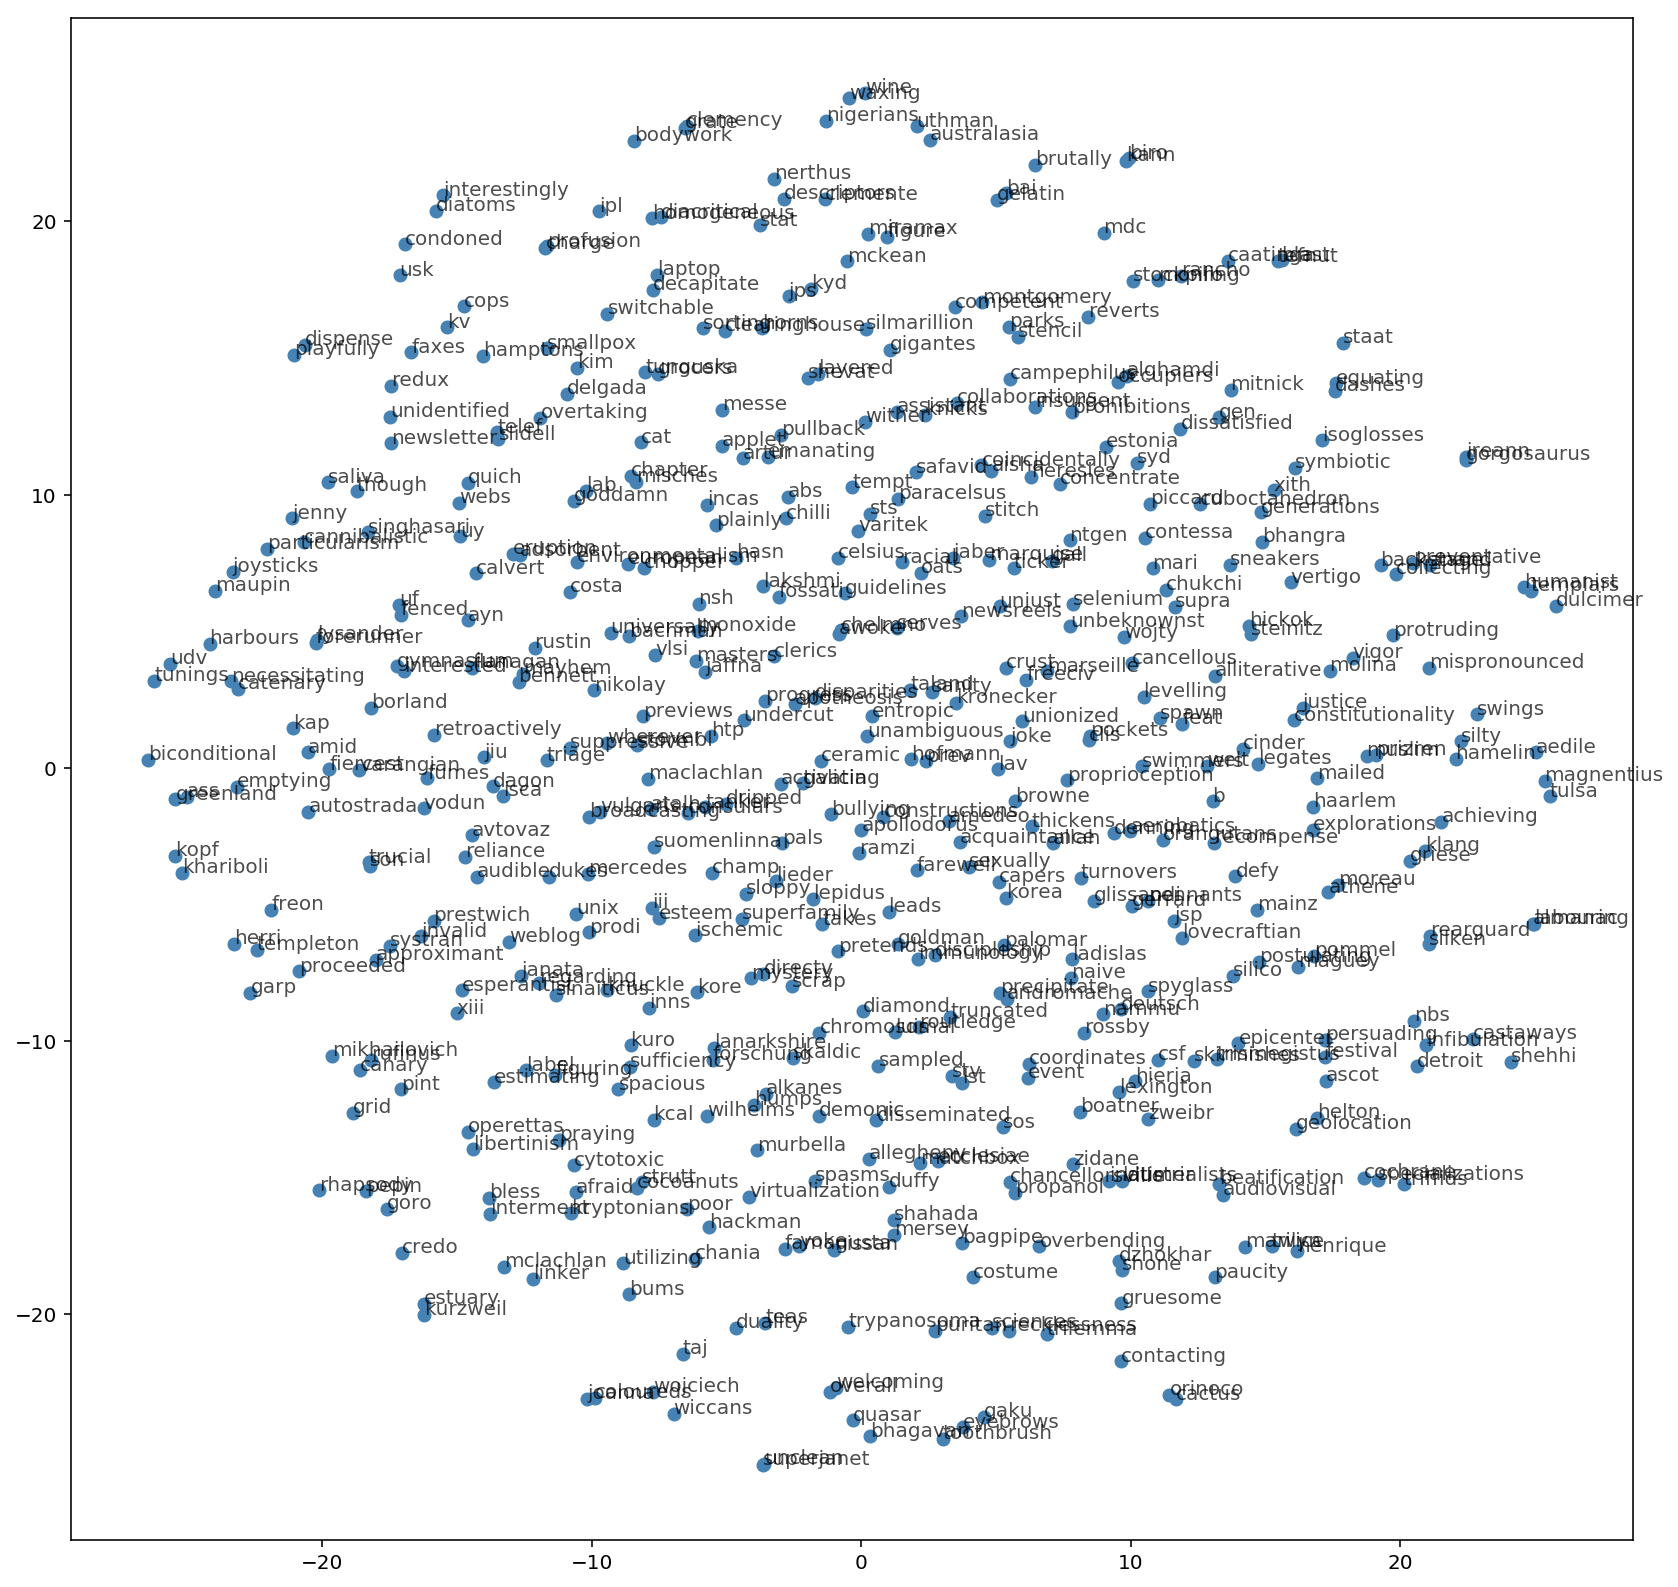

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
plt.savefig("SDG_result.jpg")